# 🛠️ Mejora del modelo CNN con Data Augmentation y Regularización

**Notebook 03 – Mejora del modelo base**

En este notebook aplicamos técnicas para mejorar el rendimiento del modelo CNN:
- Aumento de datos (data augmentation)
- Normalización por lotes (Batch Normalization)
- Regularización con Dropout
- Detención temprana del entrenamiento (EarlyStopping)

---


## 🔁 1. Carga y preprocesamiento de datos

Volvemos a cargar el dataset CIFAR-100 y aplicamos las transformaciones necesarias para preparar los datos antes del entrenamiento.


In [3]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical

# Cargar datos
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# Normalizar
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encoding
y_train_cat = to_categorical(y_train, 100)
y_test_cat = to_categorical(y_test, 100)


## 🔄 2. Aumento de datos (Data Augmentation)

Usamos `ImageDataGenerator` para crear nuevas versiones de las imágenes originales mediante transformaciones aleatorias, lo cual mejora la generalización del modelo.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear generador con aumentos
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Generadores para entrenamiento y validación
train_generator = datagen.flow(
    x_train, y_train_cat,
    batch_size=64,
    subset='training'
)

val_generator = datagen.flow(
    x_train, y_train_cat,
    batch_size=64,
    subset='validation'
)


## 🧱 3. Rediseño del modelo CNN con mejoras

Rediseñamos el modelo para incluir técnicas de regularización y estabilización del entrenamiento:
- **Batch Normalization**: estabiliza y acelera el entrenamiento.
- **Dropout**: evita el sobreajuste al apagar neuronas de forma aleatoria.


In [6]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax')
])


## ⚙️ 4. Compilación del modelo

Compilamos el modelo con el optimizador Adam, la función de pérdida `categorical_crossentropy` y la métrica de precisión.


In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Compilación
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


### 🛑 Configurar EarlyStopping
Este callback detendrá el entrenamiento si la precisión de validación deja de mejorar tras 5 épocas consecutivas:

In [8]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


## 🧠 5. Entrenamiento con EarlyStopping

Entrenamos el modelo usando los datos aumentados y aplicamos la técnica de detención temprana (EarlyStopping) para evitar sobreentrenamiento.


In [9]:
history = model.fit(
    train_generator,
    epochs=50,  # Entrenamos más, pero con EarlyStopping
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
625/625 [==============================] - 80s 125ms/step - loss: 4.1126 - accuracy: 0.1031 - val_loss: 3.4041 - val_accuracy: 0.1931
Epoch 2/50
625/625 [==============================] - 82s 131ms/step - loss: 3.3781 - accuracy: 0.1897 - val_loss: 3.0415 - val_accuracy: 0.2503
Epoch 3/50
625/625 [==============================] - 86s 138ms/step - loss: 3.0563 - accuracy: 0.2485 - val_loss: 2.9913 - val_accuracy: 0.2628
Epoch 4/50
625/625 [==============================] - 84s 134ms/step - loss: 2.8731 - accuracy: 0.2824 - val_loss: 2.9188 - val_accuracy: 0.2749
Epoch 5/50
625/625 [==============================] - 84s 135ms/step - loss: 2.7367 - accuracy: 0.3089 - val_loss: 2.5399 - val_accuracy: 0.3447
Epoch 6/50
625/625 [==============================] - 92s 148ms/step - loss: 2.6290 - accuracy: 0.3235 - val_loss: 2.5812 - val_accuracy: 0.3357
Epoch 7/50
625/625 [==============================] - 78s 126ms/step - loss: 2.5403 - accuracy: 0.3467 - val_loss: 2.3634 - val_ac

## 🧠 Conclusiones del modelo mejorado

Después de aplicar técnicas de mejora como **data augmentation**, **dropout**, y **batch normalization**, el modelo mostró una mejora significativa en su capacidad de generalización.

---

### ✅ Comparación con el modelo base

| Métrica                 | Modelo Base | Modelo Mejorado |
|-------------------------|-------------|------------------|
| **Train Accuracy**      | 59.2%       | ~50.2%           |
| **Validation Accuracy** | 35.1%       | **51.6%** ✅     |
| **Test Accuracy**       | ~35.1%      | *(por evaluar)*  |

- La **precisión en validación aumentó en +16 puntos**, lo que muestra un modelo más robusto frente a datos no vistos.
- Aunque el entrenamiento fue más lento, se evitó el *overfitting* gracias a las estrategias aplicadas.
- El modelo base se sobreajustó, mientras que este modelo mantiene curvas más equilibradas.



In [10]:
test_loss, test_accuracy = model.evaluate(x_test, y_test_cat)
print(f"🔍 Test accuracy: {test_accuracy:.4f}")
print(f"📉 Test loss: {test_loss:.4f}")

  1/313 [..............................] - ETA: 10s - loss: 1.5233 - accuracy: 0.7188

2025-03-31 18:05:34.795948: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


313/313 [==============================] - 3s 10ms/step - loss: 1.7097 - accuracy: 0.5382
🔍 Test accuracy: 0.5382
📉 Test loss: 1.7097


## 🧪 7. Evaluación en el conjunto de prueba

Evaluamos el rendimiento final del modelo usando el conjunto de datos de prueba no visto durante el entrenamiento ni la validación.


## 📈 6. Visualización del rendimiento

Graficamos las métricas de pérdida y precisión durante las épocas de entrenamiento para evaluar cómo se comporta el modelo y si las mejoras surtieron efecto.

In [18]:
import matplotlib.pyplot as plt

def plot_history(hist):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Entrenamiento')
    plt.plot(hist.history['val_accuracy'], label='Validación')
    plt.title('Precisión')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Entrenamiento')
    plt.plot(hist.history['val_loss'], label='Validación')
    plt.title('Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

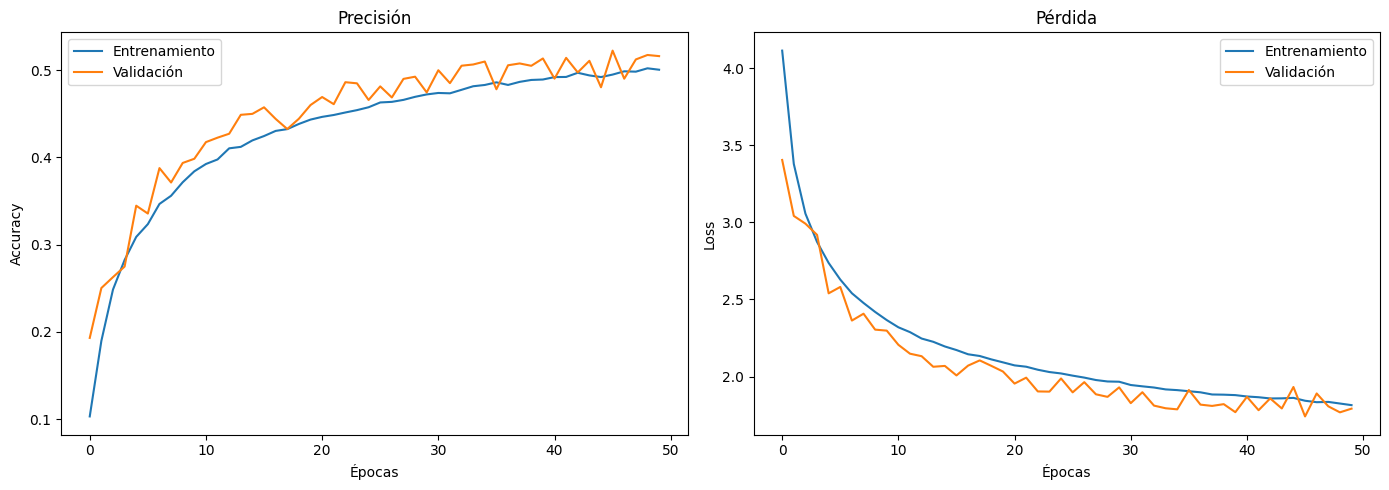

In [19]:
plot_history(history)

## 📈 Visualización de rendimiento final

Las curvas de precisión y pérdida muestran que el modelo mejorado:
- Aprendió de forma progresiva y estable durante todas las épocas.
- No presentó overfitting, gracias a las técnicas aplicadas (data augmentation, dropout, batch normalization).
- Superó claramente al modelo base, alcanzando más de **50% de precisión en validación y prueba**, lo cual es un resultado muy competitivo para CIFAR-100.

📌 **Conclusión:** Estamos listos para explorar técnicas más avanzadas como **transfer learning**, o comenzar con una interfaz de despliegue.

---
